In [7]:
#Read dataset

import pandas as pd
import numpy as np

# Read main data
data = pd.read_excel('/Users/anthony/spyder-py3/ML/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('/Users/anthony/spyder-py3/ML/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

In [8]:
#Create dummies

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Create a dummy for sunday
data['is_sunday'] = (data.index.dayofweek == 6).astype(int)

In [9]:
#Transform data
from sklearn.preprocessing import MinMaxScaler

# Scale data between 0 and 1
def scale_data(data):
    scalers = {}
    data_normalized = data.copy()
    for column in data.columns:
        scaler = MinMaxScaler()
        data_normalized[column] = scaler.fit_transform(data[[column]])
        scalers[column] = scaler
    return data_normalized, scalers


# Define a function to transfrom data for CNN model
def transform_data_cnn(data_normalized, n_steps_in, start_date, end_date):    
    X, y, dates = [], [], []
    # Filter data based on the start and end dates
    data_filtered = data_normalized[start_date:end_date]
    # Create sequence data of n_steps_in days and n_steps_out days
    for i in range(n_steps_in, len(data_filtered)):
        X.append(data_filtered.iloc[i-n_steps_in:i])
        y.append(data_filtered.iloc[i]['tg1_traffic']) #0 because we just want to predict traffic
        dates.append(data_filtered.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates





In [29]:
data_normalized, scaler = scale_data(data)

n_steps_in = 365


X_train, y_train, train_dates = transform_data_cnn(data_normalized, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2019-12-31')
X_val, y_val, val_dates = transform_data_cnn(data_normalized,
                                             n_steps_in,
                                             '2020-01-01',
                                             '2021-12-31')
X_test, y_test, test_dates = transform_data_cnn(data_normalized, 
                                                n_steps_in, 
                                                '2022-01-01', 
                                                '2023-12-31')



In [30]:
import tensorflow as tf

def custom_mape(y_true, y_pred):
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs((y_true_masked - y_pred_masked) / y_true_masked)
    return 100. * tf.reduce_mean(diff)

def custom_mae(y_true, y_pred):
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs(y_true_masked - y_pred_masked)
    return 100. * tf.reduce_mean(diff)



In [31]:
# Keras Tuner

from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Define the model-building function
def build_model(hp):
    model = Sequential()
    
    # Hyperparamètres globaux
    activation = hp.Choice('activation', ['relu', 'elu', 'selu'])
    
    # Nouvel hyperparamètre pour le nombre de couches cachées
    num_hidden_layers = hp.Choice('num_hidden_layers', [2, 3, 4, 7, 11])
    
    # Pour la première couche, nous définissons un input_shape
    filters_0 = hp.Int(f'filters_layer_0', min_value=16, max_value=128, step=16)
    kernel_size_0 = hp.Int(f'kernel_size_layer_0', min_value=3, max_value=30, step=2)
    
    model.add(Conv1D(filters=filters_0, 
                     kernel_size=kernel_size_0, 
                     activation=activation,
                     padding='same',
                     input_shape=(n_steps_in, 3)))  # n_steps_in est fixé à 90
    
    # Définition des hyperparamètres pour les couches cachées (identiques pour toutes ces couches)
    filters_hidden = hp.Int('filters_hidden', min_value=16, max_value=128, step=16)
    kernel_size_hidden = hp.Int('kernel_size_hidden', min_value=3, max_value=30, step=2)

    # Ajout du nombre requis de couches cachées
    for _ in range(1, num_hidden_layers):
        model.add(Conv1D(filters=filters_hidden, 
                         kernel_size=kernel_size_hidden, 
                         activation=activation,
                         padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    #optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    #learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    #if optimizer == 'adam':
    #    opt = legacy_optimizers.Adam(learning_rate=learning_rate)
    #elif optimizer == 'rmsprop':
    #    opt = legacy_optimizers.RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer='adam', loss=custom_mape, metrics=[custom_mape, custom_mae])
    return model


In [39]:
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import Objective
import shutil

directory_to_delete = "keras_tuner_dir"
shutil.rmtree(directory_to_delete)

early_stop = EarlyStopping(monitor='val_custom_mape', patience=10, restore_best_weights=True)

# Définissez la recherche d'hyperparamètres
tuner = BayesianOptimization(
    build_model,
    objective=Objective(name='val_custom_mape', direction='min'),  # Nous optimisons sur la MAPE
    max_trials=150,  # nombre d'essais pour le tuning
    directory='keras_tuner_dir',  # dossier pour stocker les logs
    project_name='traffic_optimization'
)

# Recherche des meilleurs hyperparamètres
tuner.search(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=20, 
    callbacks=[early_stop]
)


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 34 Complete [00h 00m 29s]
val_custom_mape: 24.462207794189453

Best val_custom_mape So Far: 20.663066864013672
Total elapsed time: 00h 18m 48s

Search: Running Trial #35

Value             |Best Value So Far |Hyperparameter
selu              |elu               |activation
7                 |2                 |num_hidden_layers
16                |16                |filters_layer_0
29                |13                |kernel_size_layer_0
64                |64                |filters_hidden
9                 |5                 |kernel_size_hidden



/Users/anthony/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Epoch 1/20


2023-08-15 13:21:49.964879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - ETA: 0s - loss: 5865.2246 - custom_mape: 5820.8770 - custom_mae: 345.2519

2023-08-15 13:21:57.143857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 10s 351ms/step - loss: 5865.2246 - custom_mape: 5820.8770 - custom_mae: 345.2519 - val_loss: 231.8139 - val_custom_mape: 233.5362 - val_custom_mae: 88.0121
Epoch 2/20
23/23 [==============================] - 3s 113ms/step - loss: 3770.3125 - custom_mape: 3743.0579 - custom_mae: 108.2032 - val_loss: 237.3705 - val_custom_mape: 240.8879 - val_custom_mae: 96.7116
Epoch 3/20
23/23 [==============================] - 2s 92ms/step - loss: 3415.5083 - custom_mape: 3414.1101 - custom_mae: 112.1044 - val_loss: 597.5226 - val_custom_mape: 603.9562 - val_custom_mae: 240.5205
Epoch 4/20
23/23 [==============================] - 2s 79ms/step - loss: 4560.5645 - custom_mape: 4532.1865 - custom_mae: 359.2182 - val_loss: 1002.0165 - val_custom_mape: 1019.0859 - val_custom_mae: 368.7119
Epoch 5/20
23/23 [==============================] - 2s 83ms/step - loss: 3356.1570 - custom_mape: 3333.1299 - custom_mae: 228.3263 - val_loss: 334.0339 - val_custom_mape: 345.1515 

KeyboardInterrupt: 

{'activation': 'elu', 'num_hidden_layers': 2, 'filters_layer_0': 16, 'kernel_size_layer_0': 13, 'filters_hidden': 64, 'kernel_size_hidden': 5}


2023-08-15 13:22:47.095451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 4s 109ms/step


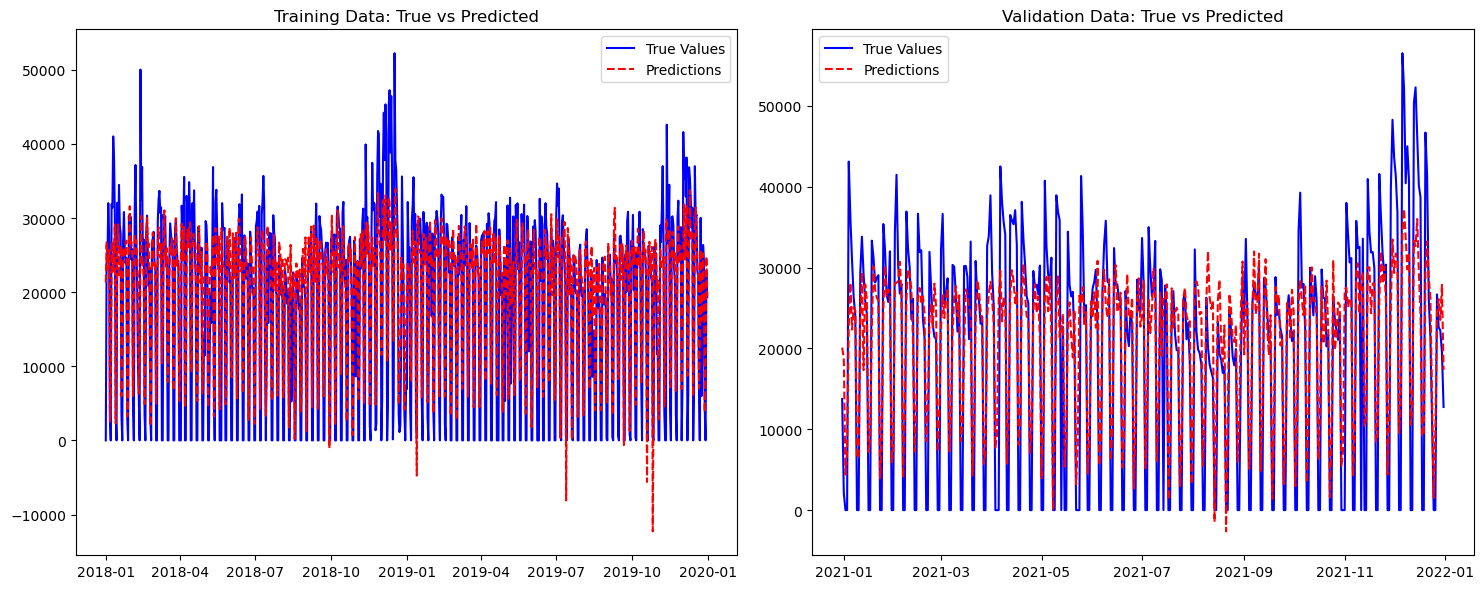

In [40]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)


# Predict on the training and validation data
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)


# Get the scaler for the target variable
target_scaler = scaler['tg1_traffic']

# Rescale predictions
y_train_pred_rescaled = target_scaler.inverse_transform(y_train_pred)
y_val_pred_rescaled = target_scaler.inverse_transform(y_val_pred)

# Rescale true values
y_train_rescaled = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_rescaled = target_scaler.inverse_transform(y_val.reshape(-1, 1))

import matplotlib.pyplot as plt

# Plot for training data
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_dates, y_train_rescaled, label='True Values', color='blue')
plt.plot(train_dates, y_train_pred_rescaled, label='Predictions', color='red', linestyle='--')
plt.title('Training Data: True vs Predicted')
plt.legend()

# Plot for validation data
plt.subplot(1, 2, 2)
plt.plot(val_dates, y_val_rescaled, label='True Values', color='blue')
plt.plot(val_dates, y_val_pred_rescaled, label='Predictions', color='red', linestyle='--')
plt.title('Validation Data: True vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()



In [17]:
def calculate_mape(y_true, y_pred):
    # Filter out the entries for which y_true is zero
    non_zero_mask = y_true != 0
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]
    
    # Calculate the MAPE
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    return mape
# Calculate MAPE for training data
mape_train = calculate_mape(y_train_rescaled.flatten(), y_train_pred_rescaled.flatten())

# Calculate MAPE for validation data
mape_val = calculate_mape(y_val_rescaled.flatten(), y_val_pred_rescaled.flatten())

print(f"MAPE on Training Data: {mape_train:.2f}%")
print(f"MAPE on Validation Data: {mape_val:.2f}%")


MAPE on Training Data: 37.00%
MAPE on Validation Data: 19.14%


In [18]:
# Afficher un résumé des résultats
tuner.results_summary()

Results summary
Results in keras_tuner_dir/traffic_optimization
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 056 summary
Hyperparameters:
activation: relu
num_hidden_layers: 2
filters_layer_0: 128
kernel_size_layer_0: 3
filters_hidden: 128
kernel_size_hidden: 15
Score: 0.06037472188472748

Trial 050 summary
Hyperparameters:
activation: relu
num_hidden_layers: 4
filters_layer_0: 80
kernel_size_layer_0: 15
filters_hidden: 80
kernel_size_hidden: 15
Score: 0.061160244047641754

Trial 118 summary
Hyperparameters:
activation: relu
num_hidden_layers: 7
filters_layer_0: 128
kernel_size_layer_0: 9
filters_hidden: 16
kernel_size_hidden: 7
Score: 0.0612114816904068

Trial 105 summary
Hyperparameters:
activation: relu
num_hidden_layers: 4
filters_layer_0: 16
kernel_size_layer_0: 15
filters_hidden: 48
kernel_size_hidden: 11
Score: 0.06151081994175911

Trial 043 summary
Hyperparameters:
activation: relu
num_hidden_layers: 2
filters_layer_0: 48
kernel_size_layer_0: 15
filt

   activation  num_hidden_layers     score  filters_layer_0  \
0        relu                  2  0.060375              128   
1        relu                  4  0.061160               80   
2        relu                  7  0.061211              128   
3        relu                  4  0.061511               16   
4        relu                  2  0.061580               48   
5        relu                  2  0.062122               64   
6        relu                  7  0.062368              112   
7        relu                  3  0.062722               16   
8        relu                  3  0.062756               16   
9        relu                  2  0.062773               80   
10       relu                  7  0.063402               16   
11       relu                  4  0.063435              128   
12       relu                  2  0.063442              128   
13       relu                  4  0.063586              128   
14       relu                  7  0.063600             

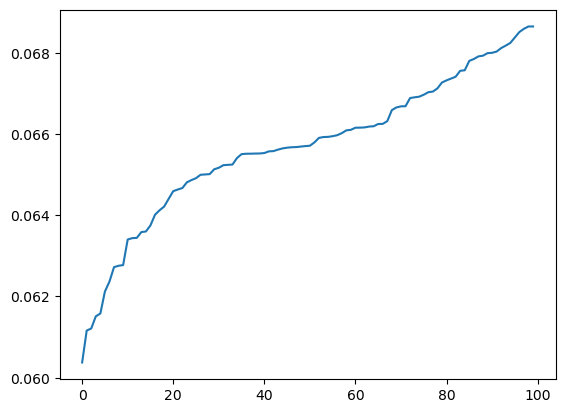

In [20]:
# Récupérer les essais
trials = tuner.oracle.get_best_trials(num_trials=100)

# Extraire les détails de chaque essai et les convertir en un DataFrame Pandas
df = pd.DataFrame([t.hyperparameters.values for t in trials])
df['score'] = [t.score for t in trials]

# Trier par score pour voir l'évolution
df = df.sort_values('score')

# Vous pouvez maintenant visualiser les données avec des graphiques, par exemple:
df['score'].plot()
print(df[['activation','num_hidden_layers','score','filters_layer_0','kernel_size_layer_0']].head(20))

